In [ ]:
!pip install tensorflow matplotlib

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import os

In [2]:
model_path = "ai_models/lite-model_movenet_singlepose_thunder_3.tflite"
template_path = "Images/fall_img_1.png"

In [3]:
interpreter = tf.lite.Interpreter(model_path= model_path)
interpreter.allocate_tensors()

In [4]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

height, width

(256, 256)

In [5]:
def thumbnail(image=None, desired_size=None):
        """Resizes original image as close as possible to desired size.
        Preserves aspect ratio of original image.
        Does not modify the original image.
        :Parameters:
        ----------
        image : PIL.Image
            Input Image for AI model detection.
        desired_size : (width, height)
            Size expected by the AI model.
        :Returns:
        -------
        PIL.Image
            Resized image fitting for the AI model input tensor.
        """
        assert image
        assert desired_size
        
        thumb = image.copy()
        w, h = desired_size
        try:
            # convert from numpy to native Python int type
            # that PIL expects
            if isinstance(w, np.generic):
                w = w.item()
                w = int(w)
                h = h.item()
                h = int(h)
            thumb.thumbnail((w, h))
        except Exception as e:
            msg = (f"Exception in "
                   f"PIL.image.thumbnail(desired_size={desired_size}):"
                   f"type(width)={type(w)}, type(height)={type(h)}"
                   f"\n{e}"
                   )
            
            raise RuntimeError(msg)
        
        return thumb


def resize(image=None, desired_size=None):
    """Pad original image to exact size expected by input tensor.
    Preserve aspect ratio to avoid confusing the AI model with
    unnatural distortions. Pad the resulting image
    with solid black color pixels to fill the desired size.
    Do not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image sized to fit an input tensor but without padding.
        Its possible that one size fits one tensor dimension exactly
        but the other size is smaller than
        the input tensor other dimension.
    desired_size : (width, height)
        Exact size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting exactly the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    delta_w = desired_size[0] - thumb.size[0]
    delta_h = desired_size[1] - thumb.size[1]
    padding = (0, 0, delta_w, delta_h)
    new_im = ImageOps.expand(thumb, padding)
    
    assert new_im.size == desired_size
    return new_im


In [6]:
template_image_src = Image.open(template_path)

_thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
template_image = resize(image=_thumbnail, desired_size=(width, height))


src_templ_height, src_tepml_width = template_image_src.size

template_image.size, src_tepml_width, src_templ_height

((256, 256), 480, 640)

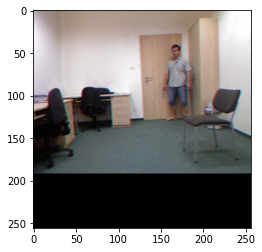

In [7]:
plt.imshow(template_image)

In [8]:
template_input = np.expand_dims(template_image.copy(), axis=0)
template_input = template_input.astype(np.float32)

In [9]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], template_input)

# Invoke inference.
interpreter.invoke()

# Get the model prediction.
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

In [10]:
def get_keypoints(keypoints_with_scores, height, width, keypoint_threshold=0.11):
  
    keypoints_all = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    
    for idx in range(num_instances):
        
        kpts_y = keypoints_with_scores[0, idx, :, 1]
        kpts_x = keypoints_with_scores[0, idx, :, 0]
        
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        
        kpts_absolute_xy = np.stack([width * np.array(kpts_x), height * np.array(kpts_y), kpts_scores], axis=-1)
        keypoints_all.append(kpts_absolute_xy)
        
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))


    return keypoints_xy

In [11]:
keypoints = get_keypoints(keypoints_with_scores, height, width)
keypoints.shape

(17, 3)

In [12]:
keypoints

array([[ 49.890293  , 167.44354   ,   0.559025  ],
       [ 47.83139   , 168.37746   ,   0.37516552],
       [ 48.403713  , 165.28372   ,   0.4915627 ],
       [ 49.477127  , 171.74347   ,   0.4811373 ],
       [ 50.644806  , 163.53908   ,   0.4744489 ],
       [ 59.27427   , 176.25403   ,   0.3685919 ],
       [ 61.76375   , 159.18721   ,   0.40784603],
       [ 72.0098    , 183.20393   ,   0.4689389 ],
       [ 74.32255   , 157.47856   ,   0.3809581 ],
       [ 82.4773    , 183.29927   ,   0.4434918 ],
       [ 87.07208   , 156.1063    ,   0.45769927],
       [ 87.3331    , 175.04742   ,   0.5072451 ],
       [ 87.987625  , 163.70422   ,   0.5318248 ],
       [106.53552   , 175.96344   ,   0.59963197],
       [106.85897   , 164.98584   ,   0.47966382],
       [124.385345  , 174.48799   ,   0.36914474],
       [124.597145  , 163.8867    ,   0.54704523]], dtype=float32)

In [13]:
def draw_kps(kps):

      pil_im = template_image
      draw = ImageDraw.Draw(pil_im)
      
      leftShoulder = False
      rightShoulder = False
      
      for i in range(kps.shape[0]):
          if kps[i, 2]:
                                  
              x, y, r = int(round(kps[i, 1])), int(round(kps[i, 0])), 1
              
              if i == 5:
                  leftShoulder = True
                  leftShoulder_point = [x, y]
                  # print("leftShoulder_point : ", leftShoulder_point)
                  
              if i == 6:
                  rightShoulder = True
                  rightShoulder_point = [x, y]
                  # print("rightShoulder_point : ", rightShoulder_point)
              
              leftUpPoint = (x-r, y-r)
              rightDownPoint = (x+r, y+r)
              twoPointList = [leftUpPoint, rightDownPoint]
              draw.ellipse(twoPointList, fill=(0, 255, 0, 255))
              
              if i == 11 and leftShoulder:
                  leftHip_point = [x, y]
                  # print("leftHip_point : ", leftHip_point)
                  draw.line((leftShoulder_point[0],leftShoulder_point[1], leftHip_point[0],leftHip_point[1]), fill='green', width=3)
              
              if i == 12 and rightShoulder:
                  rightHip_point = [x, y]
                  # print("rightHip_point : ", rightHip_point)
                  draw.line((rightShoulder_point[0],rightShoulder_point[1], rightHip_point[0],rightHip_point[1]), fill='green', width=3)
                  
      return pil_im

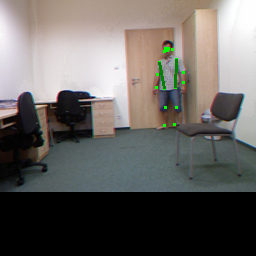

In [14]:
output_img = draw_kps(keypoints)
output_img

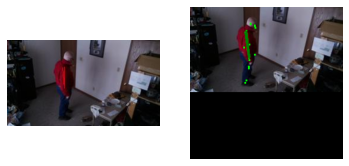

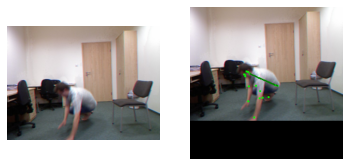

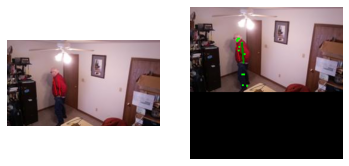

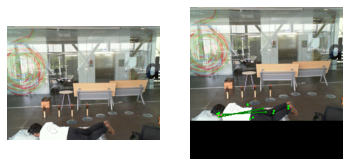

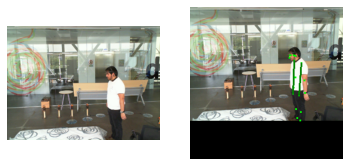

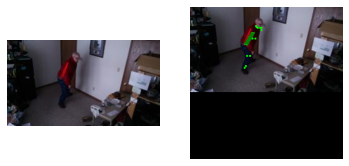

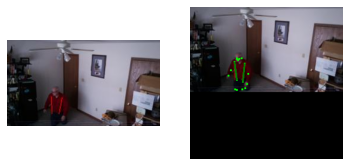

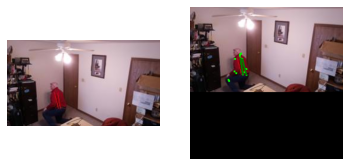

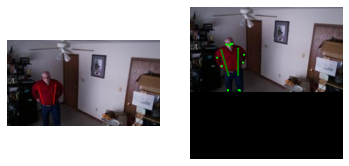

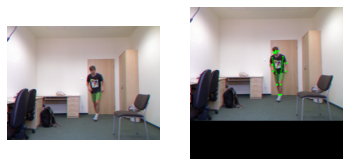

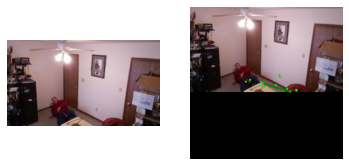

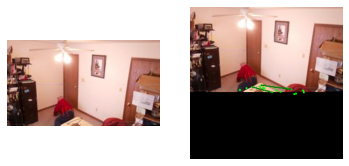

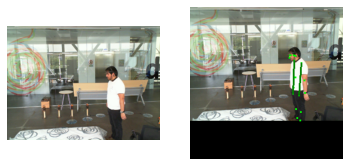

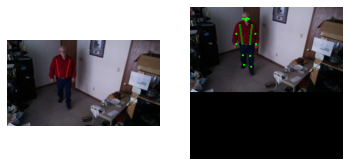

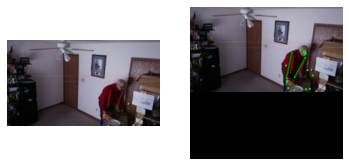

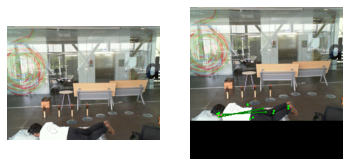

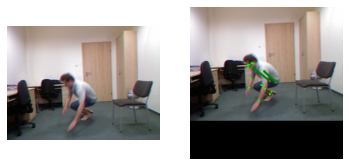

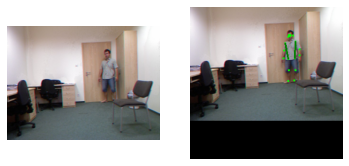

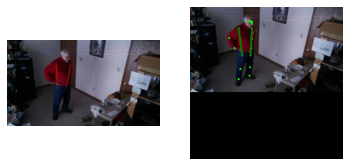

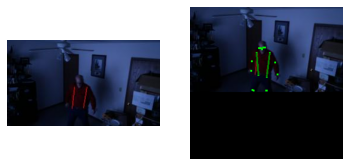

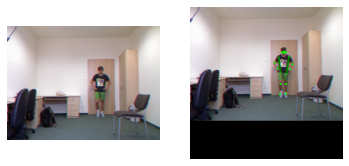

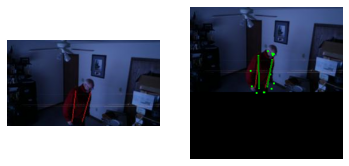

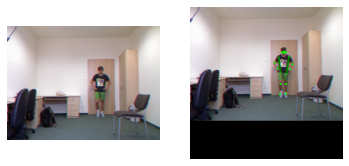

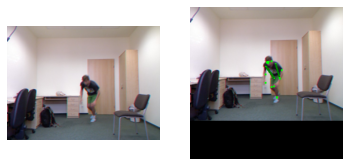

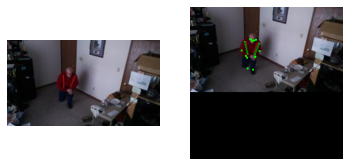

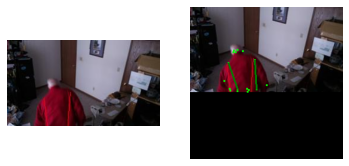

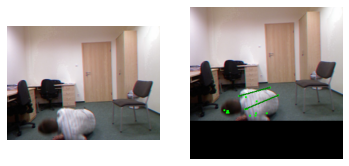

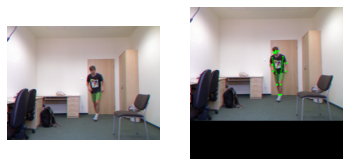

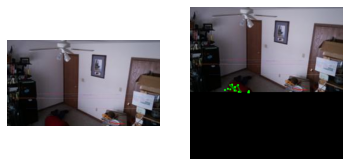

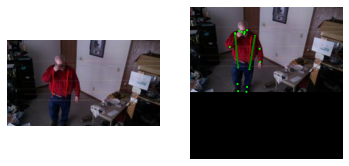

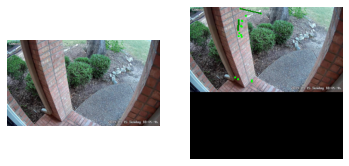

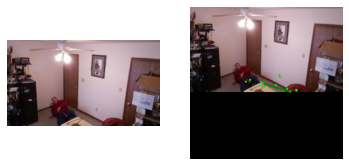

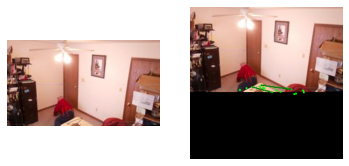

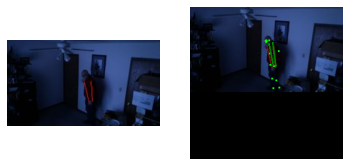

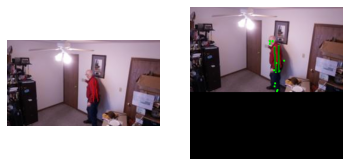

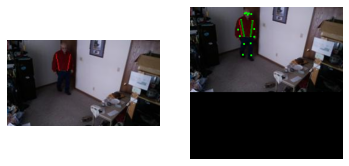

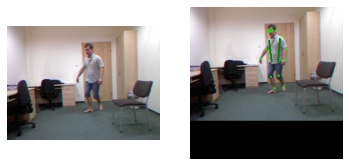

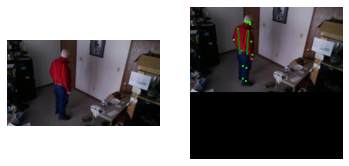

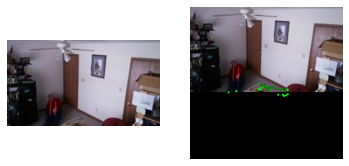

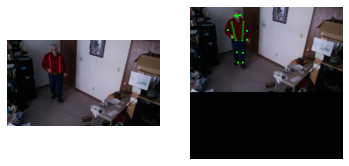

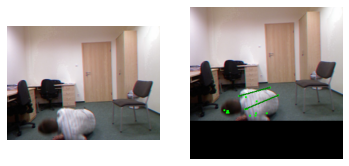

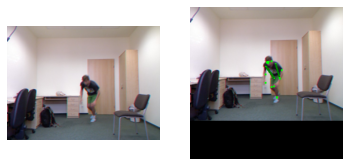

In [15]:
import os
DATADIR = 'Images'

for template_path in os.listdir(DATADIR):
  
    template_image_src = Image.open(os.path.join(DATADIR,template_path))    
    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height)) # input image
    template_image = resize(image=_thumbnail, desired_size=(width, height))
    
    template_input = np.expand_dims(template_image.copy(), axis=0)
    template_input = template_input.astype(np.float32)
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], template_input)

    # Invoke inference.
    interpreter.invoke()

    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

    keypoints = get_keypoints(keypoints_with_scores, height, width)

    output_img = draw_kps(keypoints)  # output image
    
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(_thumbnail)    
    plt.axis("off")

    fig.add_subplot(1, 2, 2)
    plt.imshow(output_img)    
    plt.axis("off")
    
    plt.show()